## Object Detection via Template Matching

In [254]:
import numpy as np
import cv
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [94]:
def imshow(img, cmap='gray', figsize=(10,8)):
    plt.figure(figsize=figsize) 
    plt.imshow(img, cmap=cmap)
    
def normalize(x, a, b):
    # return 255 * x / np.max(x)
    return (b-a) * (x - np.min(x)) / (np.max(x) - np.min(x) + 1e8) + a

def standardize(x):
    return (x - np.mean(x)) / np.std(x)

(679, 905)


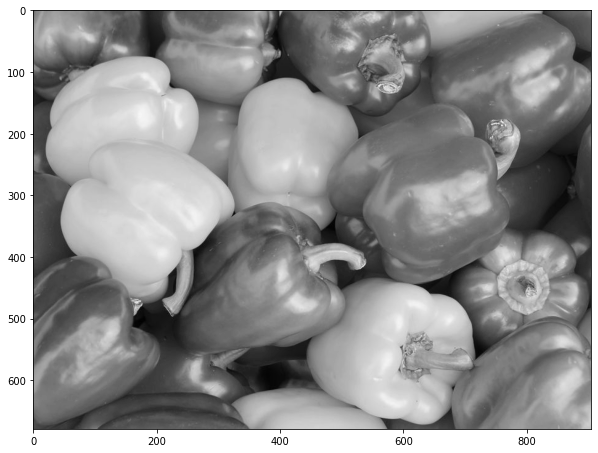

In [95]:
img = cv2.imread('./data/peppers.jpg', 0)
print(img.shape)

imshow(img)

(400, 400) 101


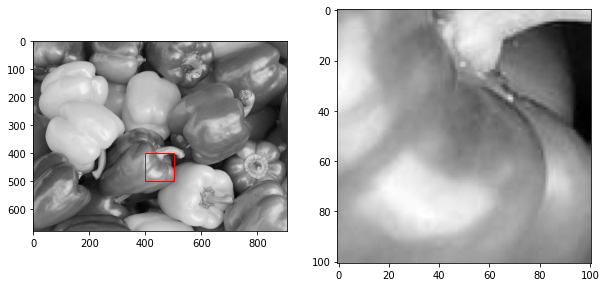

In [96]:
# Using part of the image as my template

fig, axes = plt.subplots(1, 2, figsize=(10,8))
axes[0].imshow(img, cmap='gray')

rect_coords = [(400, 501), (400, 501)]
rect_center = (rect_coords[0][0], rect_coords[1][0])
rect_len = rect_coords[0][1] - rect_coords[0][0]
print(rect_center, rect_len)

# Create a Rectangle patch
rect = patches.Rectangle(rect_center, rect_len, rect_len,
                         linewidth=1, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)

# Extract the template
template = img[rect_coords[0][0]:rect_coords[0][1], 
             rect_coords[1][0]:rect_coords[1][1]]

axes[1].imshow(template, cmap='gray')
plt.show();


In [97]:
# All the 6 methods for comparison in a list
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
img2 = img.copy()
w, h = template.shape

(401, 400)


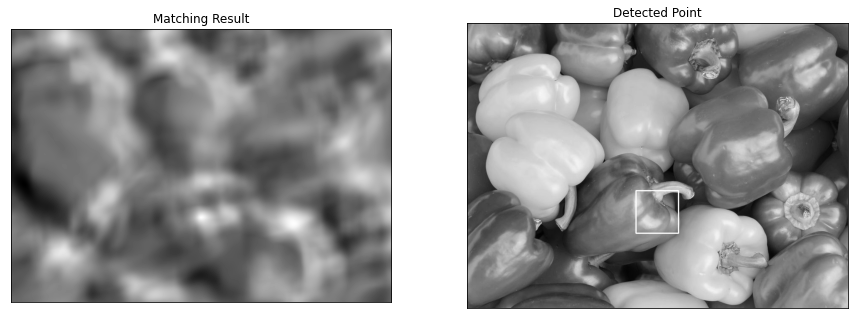

(400, 400)


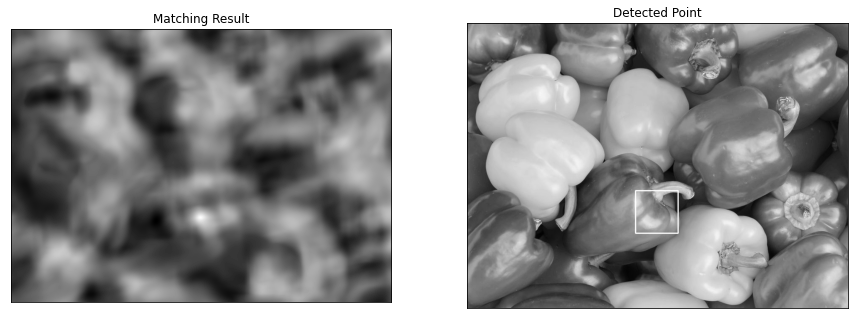

(169, 278)


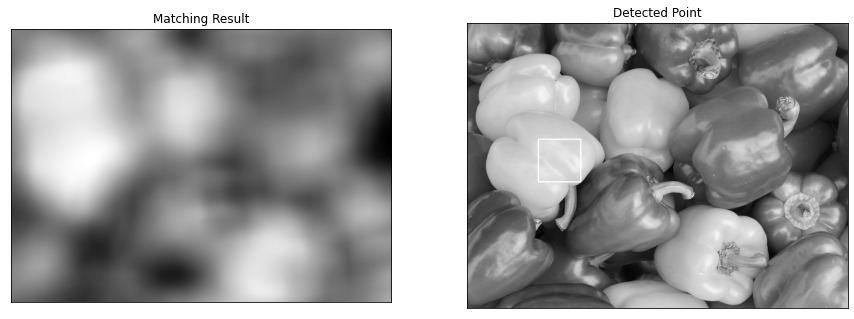

(400, 400)


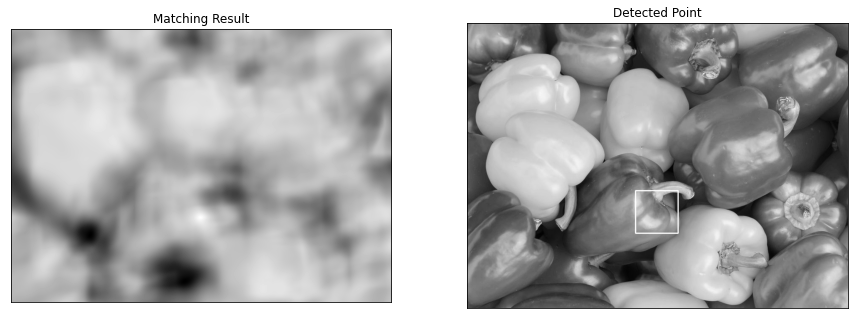

(804, 232)


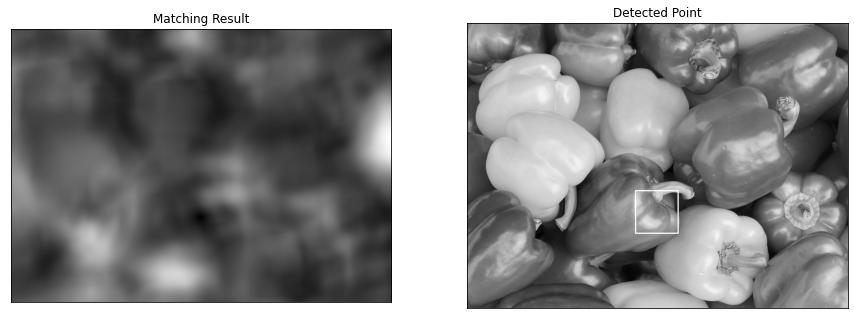

(801, 162)


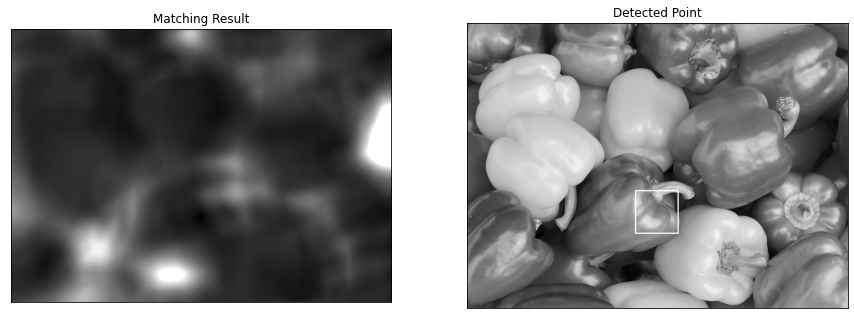

In [98]:
for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    print(max_loc)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)
    
    plt.figure(figsize=(15,15))
    plt.subplot(121), plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    #plt.suptitle(meth)

    plt.show()

In [101]:
def find_match(image, template, method=cv2.TM_CCOEFF_NORMED):
    """ Returns coordinates of highest match between image and template"""
    img = image.copy()
    # Apply template Matching
    res = cv2.matchTemplate(img, template, method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    return res, top_left, bottom_right
    

In [102]:
_, tl, br = find_match(img, template, cv2.TM_CCOEFF_NORMED)
tl, br

((399, 399), (500, 500))

### Finding multiple objects in one image 

(850, 874)


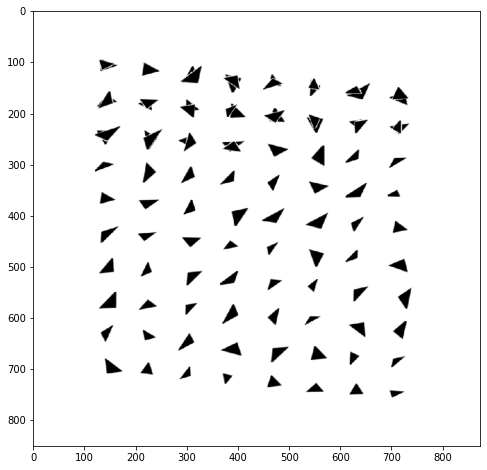

In [276]:
img = cv2.imread('./data/triangles.png', 0)
print(img.shape)

imshow(img)

(54, 78)


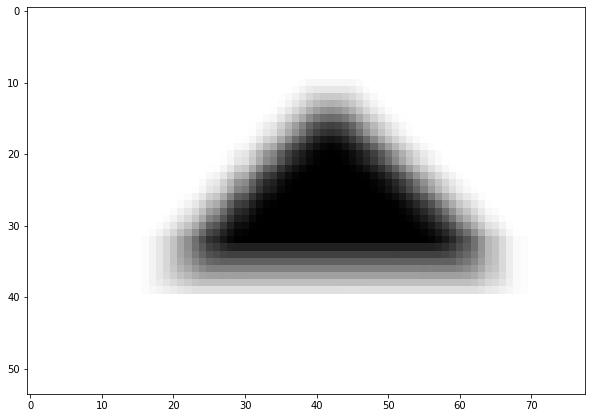

In [279]:
template = cv2.imread('./data/triangle_template.png', 0)
# template = template[30:140, 50:240]
template = cv2.resize(template, (0,0), fx=0.3, fy=0.3) 
#template = template //2
print(template.shape)

imshow(template)

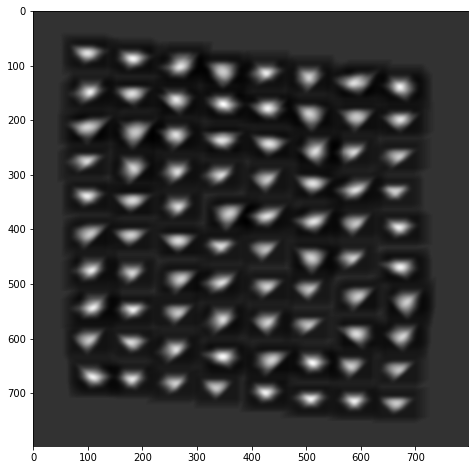

In [280]:
res, topl, botr = find_match(img, template)
imshow(res)

#### Using Non-Maximum Suppression to Detect Triangles
Basic Idea:
- Find the largest pixel value p in the image
- Store the location of p as a triangle, then set the window of values centered at p to zero
- Repeat

In [284]:
def non_max_suppression(result, templ_shape, method=cv2.TM_CCOEFF_NORMED):
    """Takes in the resulting image of an template matching """
    res = result.copy()
    #res = normalize(res, 0, 1)
    w, h = templ_shape
    max_val = 2
    
    object_points = []
    
    while max_val > 0.1:
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        #print(max_loc)
        #print(max_val)
        top_left = max_loc
        center = (top_left[0] + h//2, top_left[1] + w//2)
        
        # Zero out values around detected object
        res[top_left[1]-w//2:top_left[1]+w//2, top_left[0]-h//2:top_left[0]+h//2] = 0
        
        object_points.append(center)
        
    return res, object_points

81


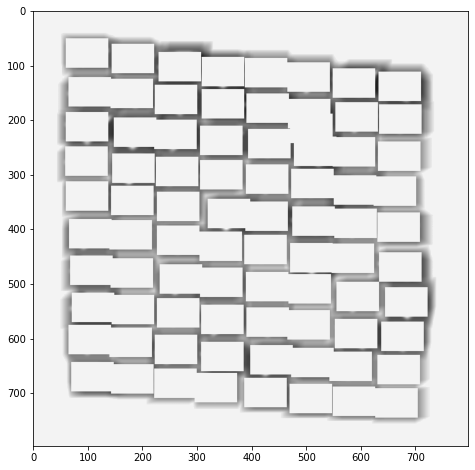

In [285]:
result, object_points = non_max_suppression(res, template.shape)
print(len(object_points))
imshow(result)

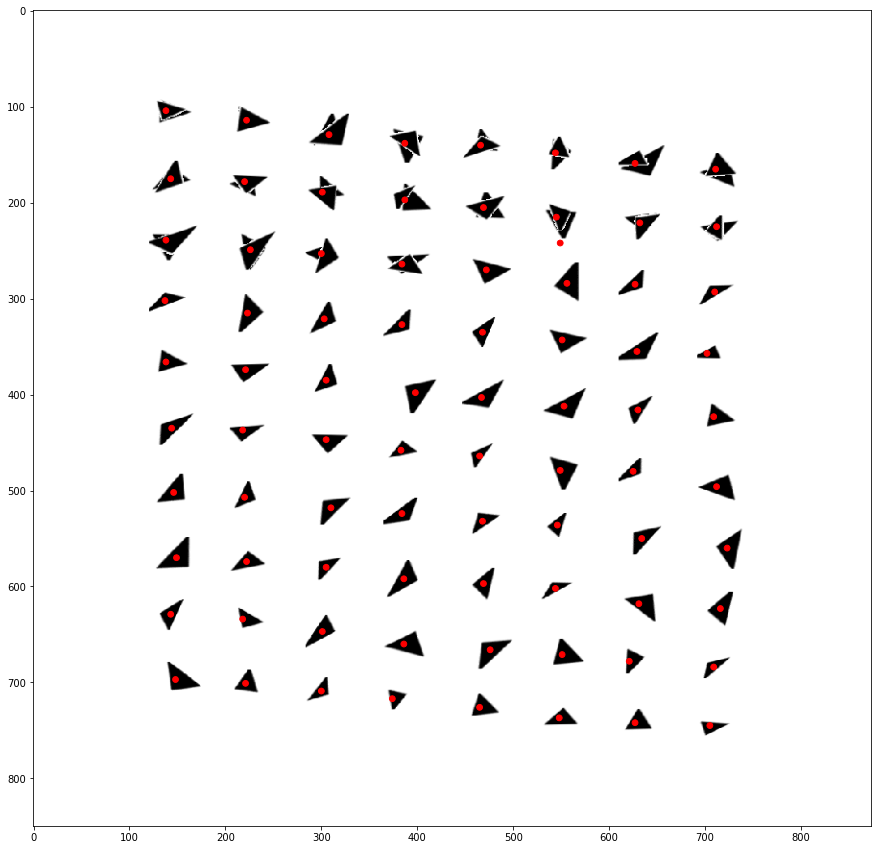

In [286]:
# Visualize detected triangles
fig,ax = plt.subplots(1, figsize=(20, 15))
ax.set_aspect('equal')

ax.imshow(img, cmap='gray')

for x,y in object_points:
    circ = patches.Circle((x,y),3, color='r')
    ax.add_patch(circ)

plt.show()